In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# السماح لـ GPU باستخدام الذاكرة تدريجيًا لتجنب kernel crash
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

2025-10-18 17:27:20.557843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760808440.784049      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760808440.849005      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ===============================================================
# 📂 المرحلة 1: تجهيز المسارات للصور والماسكات
# ===============================================================
import os

base_dir = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

image_paths = []
mask_paths = []

for folder in os.listdir(base_dir):
    path = os.path.join(base_dir, folder)

    if not os.path.isdir(path):
        continue  # ⛔ تخطّي الملفات غير الفولدرات مثل README.md

    imgs = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(".tif") and "_mask" not in f])
    masks = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(".tif") and "_mask" in f])

    image_paths.extend(imgs)
    mask_paths.extend(masks)

print(f"✅ عدد الصور: {len(image_paths)}")
print(f"✅ عدد الماسكات: {len(mask_paths)}")

assert len(image_paths) == len(mask_paths), "❌ عدد الصور والماسكات غير متطابق!"


✅ عدد الصور: 3929
✅ عدد الماسكات: 3929


NameError: name 'X_train' is not defined

In [4]:
# ===============================================================
# 🧠 المرحلة 2: تحميل الصور والماسكات ومعالجتها
# ===============================================================
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 256

X = []
Y = []

for img_path, mask_path in zip(image_paths, mask_paths):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None or mask is None:
        print(f"⚠️ مشكلة في تحميل: {img_path}")
        continue

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    img = img / 255.0
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)

    X.append(img)
    Y.append(mask)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

print(f"✅ Loaded images: {X.shape}, masks: {Y.shape}")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"✅ Train: {X_train.shape}, Test: {X_test.shape}")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(8).prefetch(tf.data.AUTOTUNE)


✅ Loaded images: (3929, 256, 256, 3), masks: (3929, 256, 256, 1)
✅ Train: (3143, 256, 256, 3), Test: (786, 256, 256, 3)


I0000 00:00:1760808574.716215      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760808574.716902      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


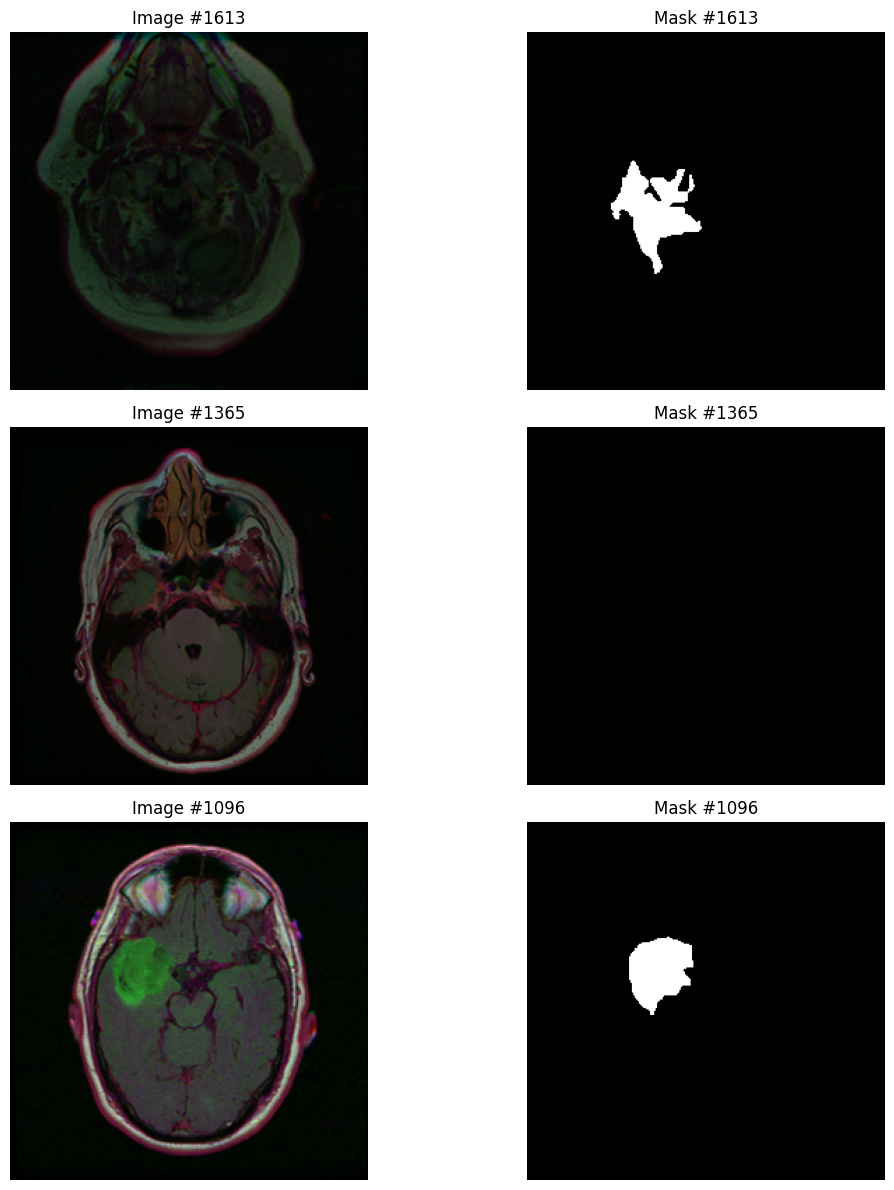

In [10]:
import matplotlib.pyplot as plt
import random
import numpy as np

num_samples = 3
indices = random.sample(range(len(X_train)), num_samples)

plt.figure(figsize=(12, 4 * num_samples))

for i, idx in enumerate(indices):
    img = X_train[idx]
    mask = Y_train[idx]

    # تأكد إن الصورة 3 قنوات
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)

    # تطبيع (لو مش مطبّع بالفعل)
    img_disp = np.clip(img, 0, 1)
    mask_disp = np.squeeze(mask)  # إزالة البعد الإضافي (H, W, 1) → (H, W)

    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(img_disp)
    plt.title(f"Image #{idx}")
    plt.axis("off")

    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(mask_disp, cmap="gray")
    plt.title(f"Mask #{idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
# ===============================================================
# 🧱 المرحلة 3: بناء موديل U-Net
# ===============================================================
from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Encoder
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
c1 = layers.Dropout(0.3)(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Dropout(0.3)(c2)
c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.Dropout(0.3)(c3)
c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

# Bottleneck
c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

# Decoder
u5 = layers.UpSampling2D((2, 2))(c4)
u5 = layers.concatenate([u5, c3])
c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
c5 = layers.Dropout(0.3)(c5)
c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

u6 = layers.UpSampling2D((2, 2))(c5)
u6 = layers.concatenate([u6, c2])
c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Dropout(0.3)(c6)
c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

u7 = layers.UpSampling2D((2, 2))(c6)
u7 = layers.concatenate([u7, c1])
c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Dropout(0.3)(c7)
c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

model = models.Model(inputs, outputs)





import tensorflow as tf
from tensorflow.keras import backend as K

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + K.epsilon())



model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric]
)




model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_60[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 256, 256,  │          0 │ conv2d_61[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ dropout_24[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128, 128,  │          0 │ conv2d_62[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 128, 128,  │    147,584 │ dropout_25[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64, 64,    │          0 │ conv2d_64[0][0]   │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 64, 64,    │    590,080 │ dropout_26[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_66[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 64, 64,    │          0 │ conv2d_67[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 64, 64,    │          0 │ up_sampling2d_12

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# ===============================================================
# 🚀 المرحلة 4: تدريب الموديل
# ===============================================================

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_unet_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1)
]



history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    batch_size=8,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 197s 466ms/step - accuracy: 0.9751 - iou_metric: 0.0027 - loss: 0.0768 - val_accuracy: 0.9897 - val_iou_metric: 0.2381 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 172s 437ms/step - accuracy: 0.9902 - iou_metric: 0.1538 - loss: 0.0359 - val_accuracy: 0.9869 - val_iou_metric: 0.2556 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 170s 433ms/step - accuracy: 0.9900 - iou_metric: 0.1526 - loss: 0.0355 - val_accuracy: 0.9895 - val_iou_metric: 0.2188 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 169s 430ms/step - accuracy: 0.9903 - iou_metric: 0.1643 - loss: 0.0339 - val_accuracy: 0.9900 - val_iou_metric: 0.1933 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 5/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 167s 425ms/step - accuracy: 0.9906 - iou_metric: 0.1701 - loss: 0.0330 - val_accuracy: 0.9904 - val_iou_metric: 0.1977 - val_loss: 0.0364 - learning_rat

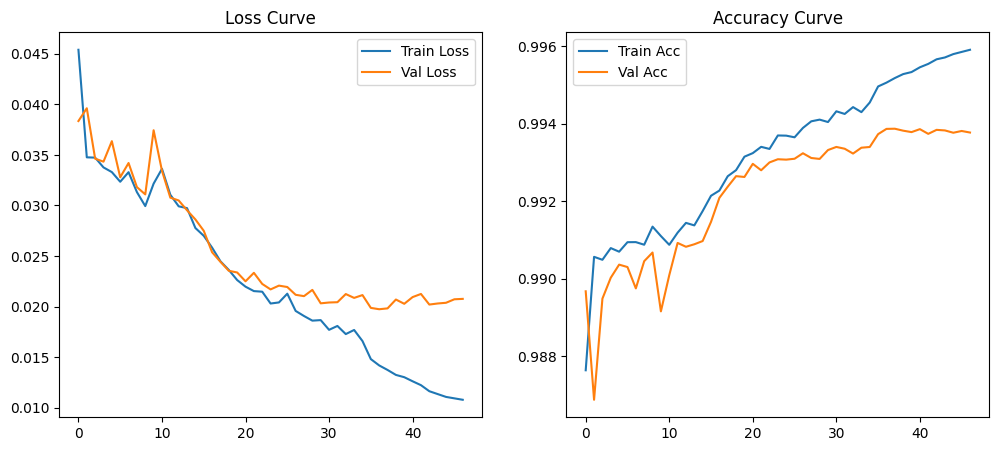

In [19]:
# ===============================================================
# 📊 المرحلة 5: رسم منحنيات التدريب
# ===============================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


In [20]:
# ===============================================================
# 🧮 المرحلة 6: Evaluation (Dice, IoU, Accuracy)
# ===============================================================
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.float32)

smooth = 1e-6
dice_scores = []
iou_scores = []
acc_per_class = []

for i in range(len(Y_test)):
    y_true = Y_test[i].flatten()
    y_p = y_pred[i].flatten()

    intersection = np.sum(y_true * y_p)
    dice = (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_p) + smooth)
    iou = (intersection + smooth) / (np.sum(y_true + y_p) - intersection + smooth)
    acc = np.mean(y_true == y_p)

    dice_scores.append(dice)
    iou_scores.append(iou)
    acc_per_class.append(acc)

dice_scores = [np.mean(dice_scores)]
iou_scores = [np.mean(iou_scores)]
acc_per_class = [np.mean(acc_per_class)]

print(f"✅ Dice: {dice_scores[0]:.4f}")
print(f"✅ IoU: {iou_scores[0]:.4f}")
print(f"✅ Accuracy: {acc_per_class[0]:.4f}")

num_classes = 1  # binary segmentation


2025-10-18 20:05:53.337860: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,256,256]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-18 20:05:53.593796: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.256124335s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,256,256]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step 
✅ Dice: 0.7608
✅ IoU: 0.7243
✅ Accuracy: 0.9939


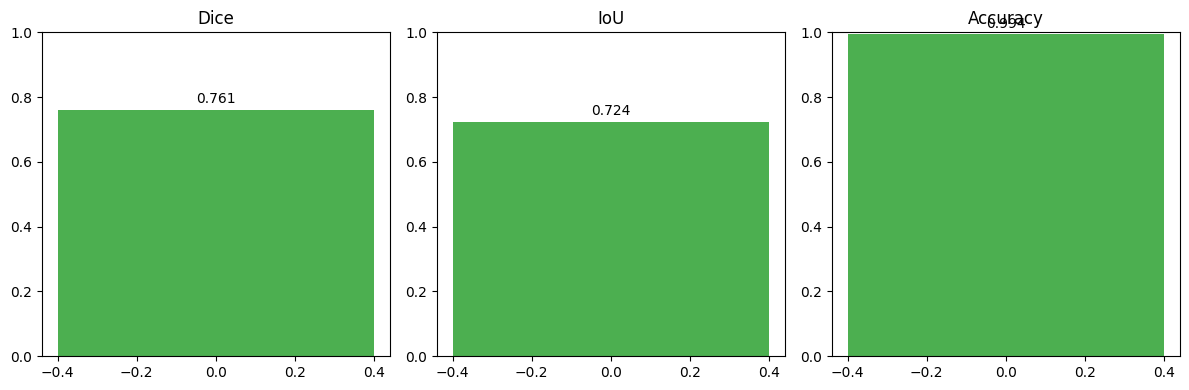

In [21]:
# ===============================================================
# 📈 المرحلة 7: Visualization of Metrics (Dice, IoU, Accuracy)
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Dice', 'IoU', 'Accuracy']
values = [dice_scores, iou_scores, acc_per_class]

plt.figure(figsize=(12,4))
for i, (metric, vals) in enumerate(zip(metrics, values)):
    plt.subplot(1,3,i+1)
    plt.bar(range(len(vals)), vals, color=['#4CAF50'])
    plt.title(metric)
    plt.ylim(0,1)
    for j, v in enumerate(vals):
        plt.text(j, v+0.02, f"{v:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# ===============================================================
# 🖼️ المرحلة 8: عرض التنبؤات (True vs Pred)
# ===============================================================
import random

n = random.randint(0, len(X_test)-1)
sample_img = X_test[n]
sample_mask_true = Y_test[n]
sample_mask_pred = y_pred[n]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(sample_img)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(sample_mask_true[:,:,0], cmap='gray')
plt.title("True Mask")

plt.subplot(1,3,3)
plt.imshow(sample_mask_pred[:,:,0], cmap='gray')
plt.title("Predicted Mask")

plt.show()
